# Supplementary materials

This notebook allows for the reproduction of the results in the paper: "Evaluating methods in image analysis challenges: lessons from MoNuSAC 2020" by Adrien Foucart, Olivier Debeir and Christine Decaestecker.

It also includes additional results that were not included in the main publication for brevity.

## Downloading the dataset

The original dataset can be downloaded from the MoNuSAC website. To work with this code, the following data are needed:

* [Testing data & annotations](https://drive.google.com/file/d/1G54vsOdxWY1hG7dzmkeK3r0xz9s-heyQ/view?usp=sharing) -> contains the .xml annotation files of the ground truth.
* Color-coded masks of the teams' predictions:
    * [SJTU 426](https://drive.google.com/file/d/1LKQMvYvmVejrIW8WRlYfabc2ZmszNEeo/view?usp=sharing)
    * [Amirreza Mahbod](https://drive.google.com/file/d/1aSEQhcrMcH1QophcK2-LobMlR0Zyhbhj/view?usp=sharing)
    * [IIAI](https://drive.google.com/file/d/115ZX6XQ76NeRRuxzKWAKrb8-irS2UQ39/view?usp=sharing)
    * [SharifHooshPardaz](https://drive.google.com/file/d/1cYP59J8huePFFRorJmA6332_K0Gs7_Tf/view?usp=sharing)
* [Color-coded ground truth masks](https://drive.google.com/file/d/1wrj2x2Kd7p-9zj1ZnNKMHCb4XqeeA71D/view?usp=sharing)

(The TIA Lab files are unfortunately unavailable due to a duplicate link to the IIAI files)

For the rest of the notebook's code to work, you need to download & extract the testing data & annotations and the teams' prediction, and put them into the following folder structure:

* DIRECTORY
    * MoNuSAC Testing Data and Annotations
    * MoNuSAC_Testing_Color_Coded_Masks
    * Teams
        * Amirreza Mahbod
        * IIAI
        * SharifHooshPardaz
        * SJTU_426

Set DIRECTORY to the correct folder in the cell below and execute it first:

In [1]:
DIRECTORY = "E:/data/MoNuSAC"

# imports
%matplotlib inline
import os
import statistics
import numpy as np
import pickle
import random
from matplotlib import pyplot as plt
from skimage.io import imread
from scipy.stats import friedmanchisquare
import scikit_posthocs as sp
from nary_masks_ops import generate_nary_from_colorcoded, generate_masks, ClassLabels
from rgb_ops import extract_all_tifs
from display_ops import show_image_and_classes, select_random_image
from matching_ops import match_strict_iou, match_centroid_rule, compute_all_matches
from metrics_ops import ImagePQMetric, getTeamPQs, getTeamDQSQs, ImageSeparatedMetrics, getTeamHausdorffDistances, compute_all_hausdorff_distances

methods = {
    '_border-removed_nary_strict-iou': 'Border-removed strict IoU',
    '_border-dilated_nary_strict-iou': 'Border-dilated strict IoU',
    '_border-removed_nary_centroid': 'Border-removed centroid',
    '_border-dilated_nary_centroid': 'Border-dilated centroid'
}

gt_dir = os.path.join(DIRECTORY, "MoNuSAC Testing Data and Annotations")
ccgt_dir = os.path.join(DIRECTORY, "MoNuSAC_Testing_Color_Coded_Masks")
teams_dir = os.path.join(DIRECTORY, "Teams")
teams = os.listdir(teams_dir)

## Preparing the dataset

**This section of the notebook take a significant amount of time to execute**. It performs essential steps for the computation of the metrics:
* Generating n-ary masks from the color-coded masks (for the teams predictions and the color-coded ground truth), using the border-removed and the border-dilated methods.
* Generating n-ary masks from the .xml annotations.
* Extracting images from the .svs slides and saving them as .tif files.
* Pre-computing & saving all the matching pairs of objects for all teams.

These steps are provided for full reproducibility. Alternatively, all the .pkl files generated from this step and used for the rest of the experiments can be downloaded from : 

[DOWNLOAD PICKLE FILES](https://u.pcloud.link/publink/show?code=XZFpW6XZhAwEbz3wzE4FB2ydi2RzFFv9egxk)

* **Uncomment and run the first cell below** to recompute all the n-ary masks and save the files.
* **Run the second cell below** to load the n-ary masks into dictionaries.
* **Uncomment and run the third cell below** to recompute all the matching pairs of objects. Otherwise, if the .pkl files were downloaded and put in the right directories, they will be loaded as needed by the rest of the code.

In [ ]:
'''
# n-ary masks from color-coded masks
generate_nary_from_colorcoded(teams_dir, ccgt_dir)

# n-ary masks from .xml annotations
generate_masks(gt_dir)

# .tif extraction
extract_all_tifs(gt_dir)
'''

In [2]:
# load ground truth n-ary masks generated from .xml annotations as dictionary:
# accessed as gt_nary_masks[patient][image] -> np.array with 2 channels (object instance, object class)
with open(os.path.join(gt_dir, "nary_masks.pkl"), "rb") as fp:
    gt_nary_masks = pickle.load(fp)

# load team prediction masks:
# accessed as teams_masks[team][method][patient][image] -> np.array with 2 channels (object instance, object class)
teams_masks = {}
for team in teams:
    team_dir = os.path.join(teams_dir, team)
    teams_masks[team] = {}
    with open(os.path.join(team_dir, "border-removed_nary.pkl"), "rb") as fp:
        teams_masks[team]['border-removed'] = pickle.load(fp)
    with open(os.path.join(team_dir, "border-dilated_nary.pkl"), "rb") as fp:
        teams_masks[team]['border-dilated'] = pickle.load(fp)

# load ground truth n-ary masks generated from color-coded mask 
# accessed as ccgt_masks[method][patient][image] -> np.array with 2 channels (object instance, object class)
ccgt_masks = {}
with open(os.path.join(ccgt_dir, "border-removed_nary.pkl"), "rb") as fp:
    ccgt_masks['border-removed'] = pickle.load(fp)
with open(os.path.join(ccgt_dir, "border-dilated_nary.pkl"), "rb") as fp:
    ccgt_masks['border-dilated'] = pickle.load(fp)

In [ ]:
'''
# Pre-compute all matches. NOTE: THIS TAKES A LOT OF TIME TO COMPUTE.
compute_all_matches(teams_dir, ccgt_dir, teams_masks, ccgt_masks, gt_nary_masks)

# Pre-compute all hausdorff distances. THIS ALSO TAKES A WHILE...
compute_all_hausdorff_distances(teams_dir, teams_masks, gt_nary_masks, methods, DIRECTORY)
'''

## Computing results

This section reproduces all the results in the publication, as well as results that were not included for brevity.

### Robustness of the PQ metric

In [3]:
# Loading all results and preparing the PQ computation 
teamPQs = [[] for _ in methods]

for team in teams:
    for idm,ext in enumerate(methods):
        team_dir = os.path.join(teams_dir, team)
        teamPQs[idm].append(getTeamPQs(team_dir,ext))

ccgt_dir = os.path.join(DIRECTORY, "MoNuSAC_Testing_Color_Coded_Masks")
ccgtPQs = {}
for idm,ext in enumerate(methods):
    ccgtPQs[idm] = getTeamPQs(ccgt_dir,ext)

**Table 1**

In [4]:
print("a-PQ")
output_table = [["\t\t\t", "Team 1", "Team 2", "Team 3", "Team 4", "CCGT"]]
for idm,ext in enumerate(methods):
    output_table.append([f"{methods[ext].ljust(24)}"] + 
                        [f"{statistics.mean(teamPQs[idm][idt]):.3f}" for idt in range(4)] +
                        [f"{statistics.mean(ccgtPQs[idm]):.3f}"])
for row in output_table:
    print('\t'.join(row))

a-PQ
				Team 1	Team 2	Team 3	Team 4	CCGT
Border-removed strict IoU	0.559	0.545	0.541	0.560	0.892
Border-dilated strict IoU	0.572	0.561	0.504	0.555	0.913
Border-removed centroid 	0.574	0.562	0.554	0.568	0.892
Border-dilated centroid 	0.586	0.574	0.516	0.561	0.913


**Figure 4**

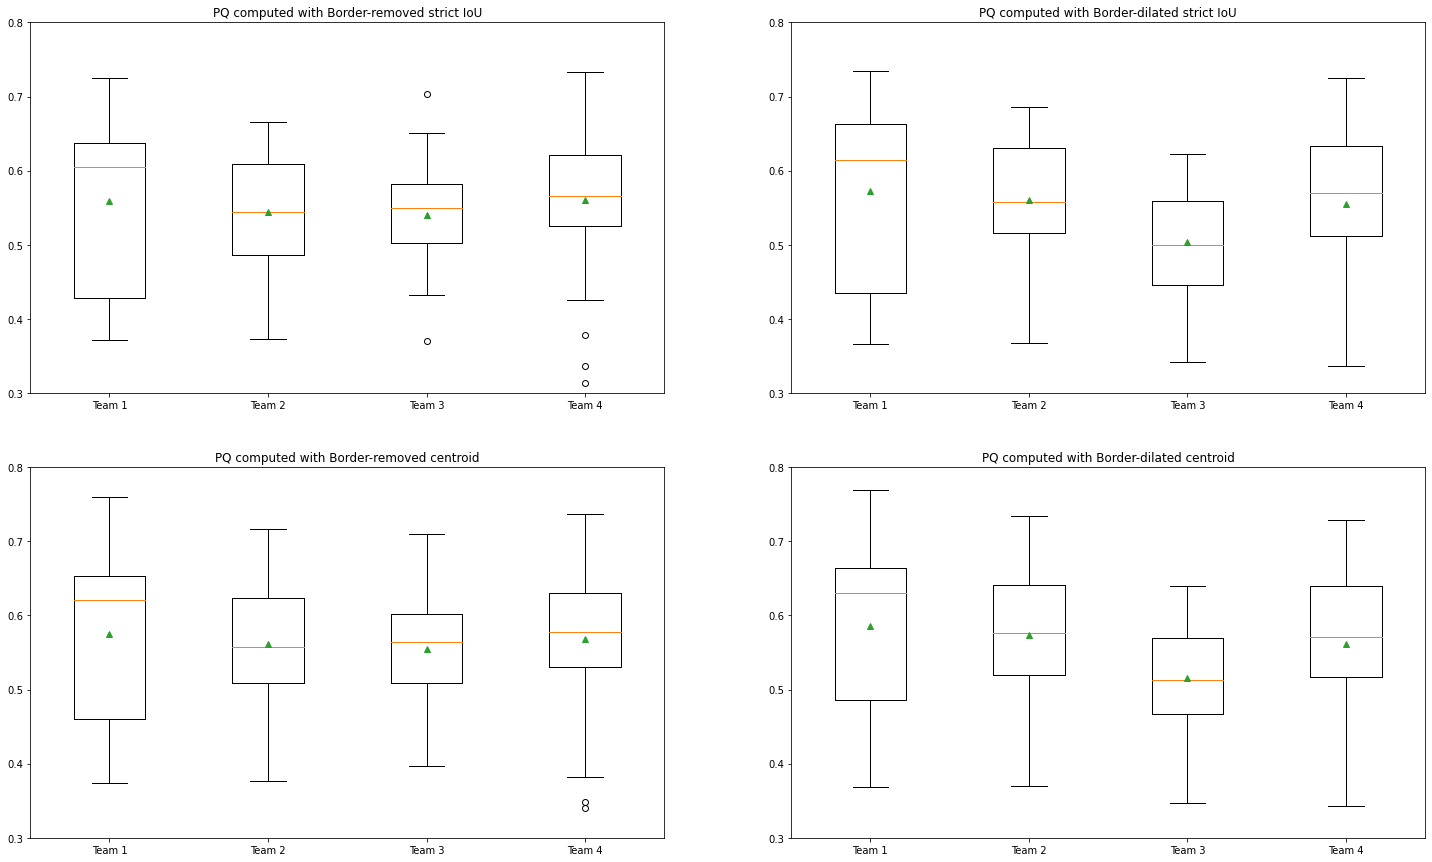

In [7]:
plt.figure(figsize=(25,15))
for idm,ext in enumerate(methods):
    plt.subplot(2,2,idm+1)
    plt.boxplot([teamPQs[idm][idt] for idt in range(4)], labels=[f"Team {idt+1}" for idt in range(4)], showmeans=True)
    plt.title(f"PQ computed with {methods[ext]}")
    plt.ylim([0.3,0.8])
plt.show()

Related **statistical tests**

In [8]:
for idm,ext in enumerate(methods):
    print(f"== {methods[ext]} ==")
    s,pvalue = friedmanchisquare(*teamPQs[idm])
    print(f"Friedman p-value: {pvalue}")
    if pvalue < 0.05:
        pvals = sp.posthoc_nemenyi_friedman(np.array(teamPQs[idm]).T)
        print(pvals)

== Border-removed strict IoU ==
Friedman p-value: 0.05975651025970441
== Border-dilated strict IoU ==
Friedman p-value: 0.000942298557379717
          0         1         2         3
0  1.000000  0.900000  0.005604  0.900000
1  0.900000  1.000000  0.002572  0.900000
2  0.005604  0.002572  1.000000  0.011606
3  0.900000  0.900000  0.011606  1.000000
== Border-removed centroid ==
Friedman p-value: 0.2177049960259662
== Border-dilated centroid ==
Friedman p-value: 0.001659709771363887
         0         1         2        3
0  1.00000  0.900000  0.016380  0.90000
1  0.90000  1.000000  0.002572  0.90000
2  0.01638  0.002572  1.000000  0.01638
3  0.90000  0.900000  0.016380  1.00000


### Decomposition of the PQ

**Figure 5**

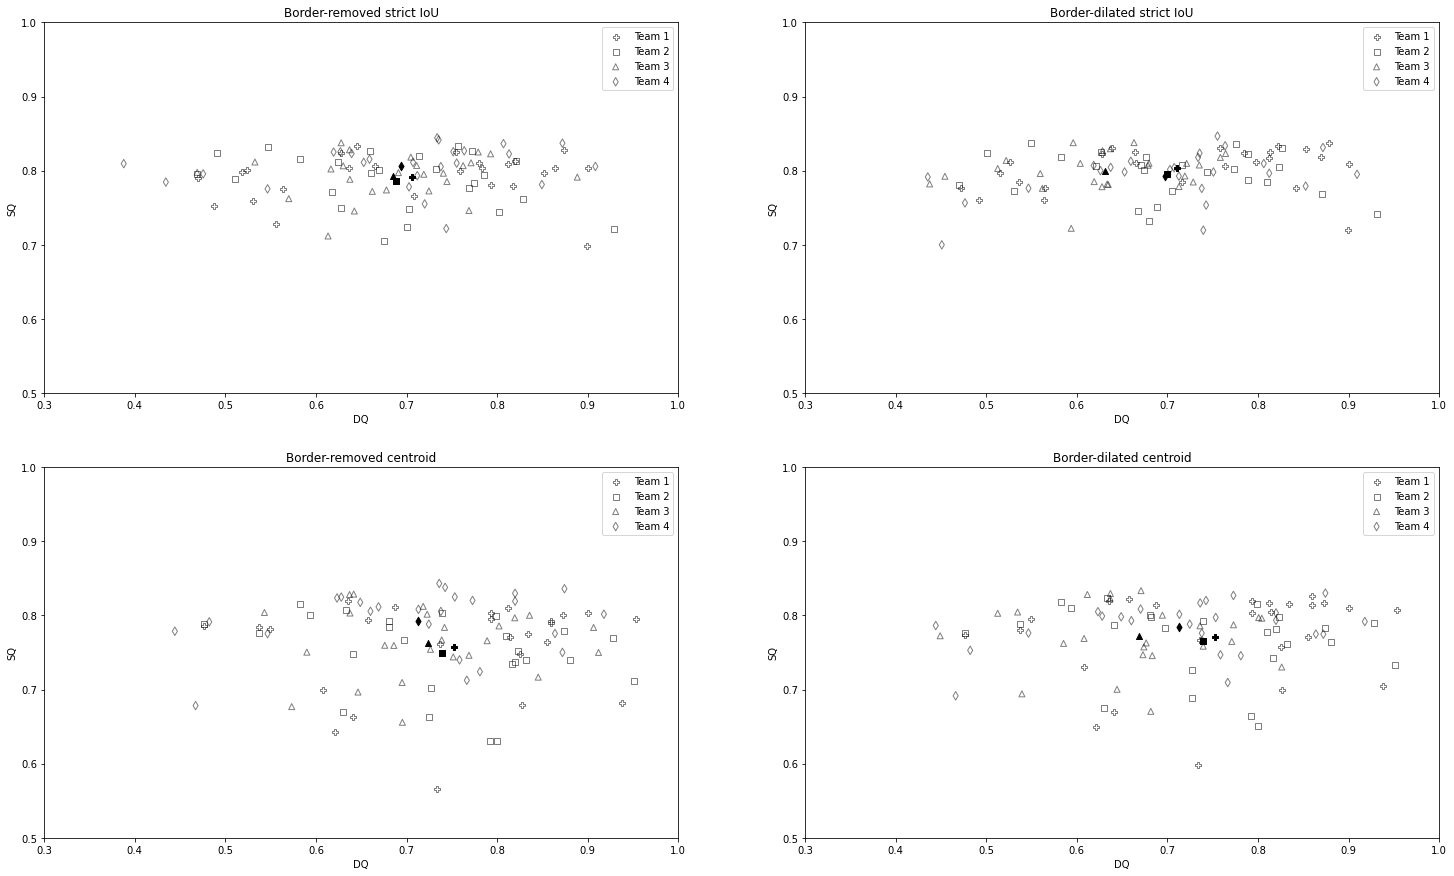

In [19]:
teamDQSQs = [[] for _ in methods]

for team in teams:
    for idm,ext in enumerate(methods):
        team_dir = os.path.join(teams_dir, team)
        teamDQSQs[idm].append(getTeamDQSQs(team_dir,ext))
    
#colors = ['b','r','k','y']
symbols = ['P', 's', '^', 'd'] # black & white version

plt.figure(figsize=(25, 15))
for idm,ext in enumerate(methods):
    plt.subplot(2,2,idm+1)
    for idt,team in enumerate(teams):
        dqs = []
        sqs = []
        for dq,sq in teamDQSQs[idm][idt]:
            dqs.append(dq)
            sqs.append(sq)
        plt.scatter(dqs,sqs,marker=f"{symbols[idt]}",facecolor='none', edgecolor='k', label=f"Team {idt+1}", alpha=0.5)
        plt.scatter(statistics.mean(dqs),statistics.mean(sqs),marker=f"{symbols[idt]}",facecolor='k', zorder=2)
    plt.xlabel('DQ')
    plt.ylabel('SQ')
    plt.xlim([0.3,1.])
    plt.ylim([0.5,1.])
    plt.legend()
    plt.title(methods[ext])
plt.show()

For the color-coded ground truth:

Border-removed strict IoU : avg DQ = 0.986, avg SQ = 0.905
Border-dilated strict IoU : avg DQ = 0.986, avg SQ = 0.925
Border-removed centroid : avg DQ = 0.986, avg SQ = 0.905
Border-dilated centroid : avg DQ = 0.986, avg SQ = 0.925


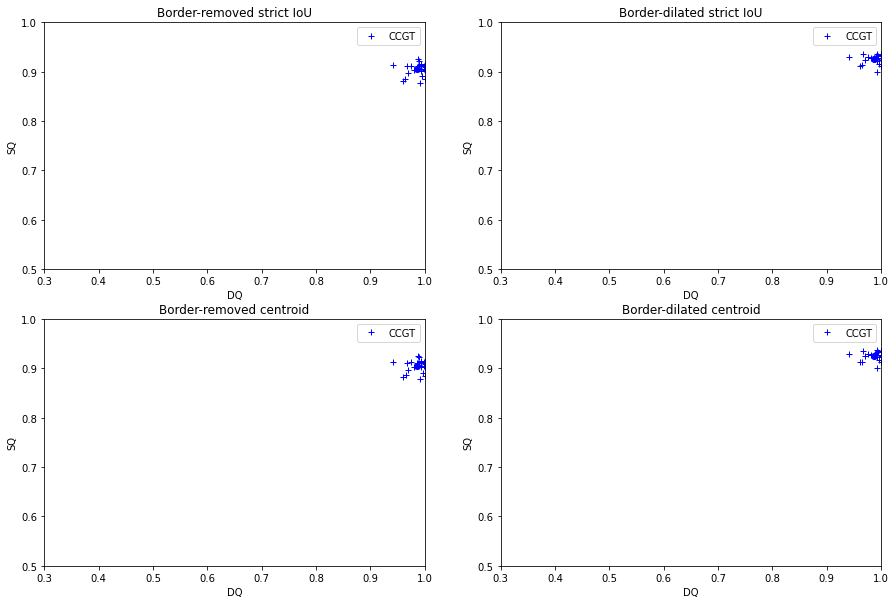

In [26]:
ccgt_dir = os.path.join(DIRECTORY, "MoNuSAC_Testing_Color_Coded_Masks")
ccgtDQSQs = [[] for _ in methods]

for idm,ext in enumerate(methods):
    ccgtDQSQs[idm] = getTeamDQSQs(ccgt_dir,ext)

colors = ['b','r','k','y']

plt.figure(figsize=(15,10))
for idm,ext in enumerate(methods):
    plt.subplot(2,2,idm+1)
    dqs = []
    sqs = []
    for dq,sq in ccgtDQSQs[idm]:
        dqs.append(dq)
        sqs.append(sq)
    plt.plot(dqs,sqs,f"{colors[0]}+",label=f"CCGT", zorder=1)
    plt.plot(statistics.mean(dqs),statistics.mean(sqs),f"{colors[0]}o", zorder=2)
    print(f"{methods[ext]} : avg DQ = {statistics.mean(dqs):.3f}, avg SQ = {statistics.mean(sqs):.3f}")
    plt.xlabel('DQ')
    plt.ylabel('SQ')
    plt.xlim([0.3,1.])
    plt.ylim([0.5,1.])
    plt.legend()
    plt.title(methods[ext])
plt.show()

### Fully separated metrics

In [20]:
# Preparing the computations
teamSM = [{} for _ in teams]
for idt,team in enumerate(teams):
    team_dir = os.path.join(teams_dir, team)
    patients = [f for f in os.listdir(team_dir) if f.startswith('TCGA')]
    for ext in methods:
        teamSM[idt][ext] = []
        for patient in patients:
            patient_dir = os.path.join(team_dir, patient)
            pkls = [os.path.join(patient_dir,f) for f in os.listdir(patient_dir) if f.endswith(f'{ext}.pkl')]
            SM_patient = ImageSeparatedMetrics()
            SM_patient.addAll(pkls)
            teamSM[idt][ext].append(SM_patient)

Detection metrics **Figure 6** and additional tables

Border-removed strict IoU
   	acc	prec	rec	f1
Team 1	0.790	0.863	0.904	0.880
Team 2	0.796	0.872	0.902	0.885
Team 3	0.703	0.794	0.862	0.823
Team 4	0.832	0.888	0.931	0.906
===
Border-dilated strict IoU
   	acc	prec	rec	f1
Team 1	0.804	0.871	0.913	0.889
Team 2	0.811	0.882	0.912	0.895
Team 3	0.668	0.754	0.857	0.799
Team 4	0.827	0.886	0.928	0.903
===
Border-removed centroid
   	acc	prec	rec	f1
Team 1	0.860	0.904	0.948	0.923
Team 2	0.852	0.906	0.936	0.919
Team 3	0.765	0.834	0.904	0.865
Team 4	0.869	0.910	0.954	0.928
===
Border-dilated centroid
   	acc	prec	rec	f1
Team 1	0.860	0.905	0.948	0.923
Team 2	0.852	0.906	0.936	0.919
Team 3	0.731	0.796	0.903	0.842
Team 4	0.869	0.910	0.954	0.928
===


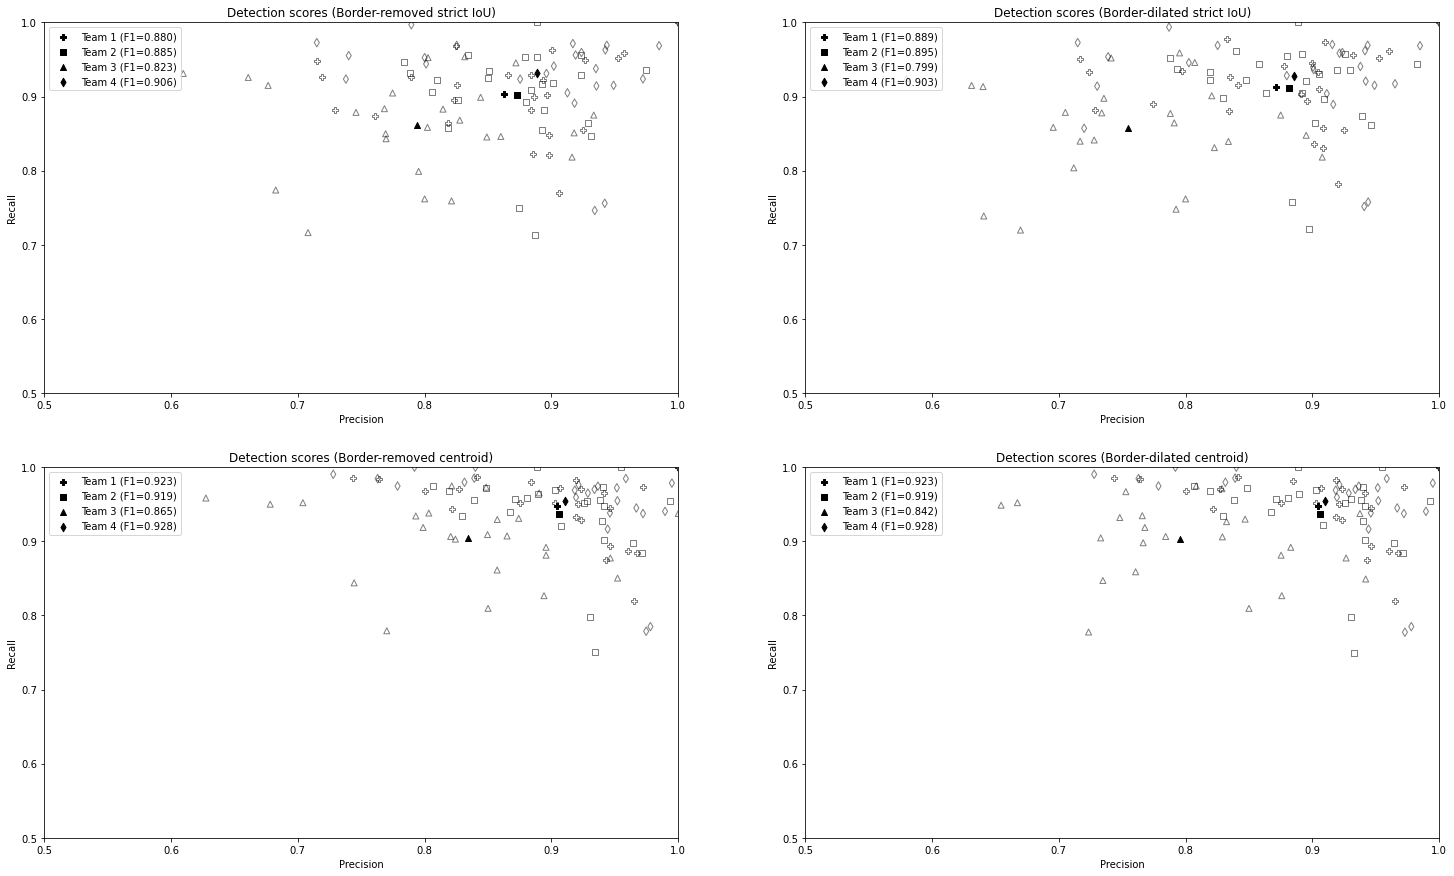

In [23]:
teamF1s = [[] for _ in range(4)]
symbols = ['P', 's', '^', 'd'] # black & white version

plt.figure(figsize=(25,15))
for ide,ext in enumerate(methods):
    output_table = [['   ', 'acc', 'prec', 'rec', 'f1']]
    print(methods[ext])
    plt.subplot(2,2,ide+1)
    for idt,team in enumerate(teams):
        accs = []
        precs = []
        recs = []
        f1s = []
        for SM in teamSM[idt][ext]:
            detection = SM.compute_detection_scores()
            accs.append(detection['acc'])
            precs.append(detection['prec'])
            recs.append(detection['rec'])
            f1s.append(detection['f1'])
            plt.scatter(detection['prec'], detection['rec'], marker=f"{symbols[idt]}", facecolor='none', edgecolor='k', alpha=0.5, zorder=1)
        output_table += [[f'Team {idt+1}', f'{statistics.mean(accs):.3f}', f'{statistics.mean(precs):.3f}', f'{statistics.mean(recs):.3f}', f'{statistics.mean(f1s):.3f}']]
        teamF1s[ide].append(f1s)
        plt.scatter(statistics.mean(precs), statistics.mean(recs), marker=f"{symbols[idt]}", facecolor='k', edgecolor='k', label=f"Team {idt+1} (F1={statistics.mean(f1s):.3f})", zorder=2)
    plt.legend(loc='upper left')
    plt.title(f"Detection scores ({methods[ext]})")
    plt.xlabel('Precision')
    plt.ylabel('Recall')
    plt.xlim([0.5,1])
    plt.ylim([0.5,1])
    for line in output_table:
        print('\t'.join(line))
    print("===")
plt.show()

Related **statistical analysis**

In [24]:
for idm,ext in enumerate(methods):
    print(f"== {methods[ext]} ==")
    s,pvalue = friedmanchisquare(*teamF1s[idm])
    print(f"Friedman p-value: {pvalue}")
    if pvalue < 0.05:
        pvals = sp.posthoc_nemenyi_friedman(np.array(teamF1s[idm]).T)
        print(pvals)

== Border-removed strict IoU ==
Friedman p-value: 2.1169465178027893e-10
          0         1         2         3
0  1.000000  0.701016  0.001387  0.011606
1  0.701016  1.000000  0.001000  0.178105
2  0.001387  0.001000  1.000000  0.001000
3  0.011606  0.178105  0.001000  1.000000
== Border-dilated strict IoU ==
Friedman p-value: 2.5570990464697465e-10
          0         1      2         3
0  1.000000  0.762506  0.001  0.042567
1  0.762506  1.000000  0.001  0.324743
2  0.001000  0.001000  1.000  0.001000
3  0.042567  0.324743  0.001  1.000000
== Border-removed centroid ==
Friedman p-value: 1.4550805506056901e-08
          0         1      2         3
0  1.000000  0.900000  0.001  0.244488
1  0.900000  1.000000  0.001  0.141637
2  0.001000  0.001000  1.000  0.001000
3  0.244488  0.141637  0.001  1.000000
== Border-dilated centroid ==
Friedman p-value: 9.144237811278471e-10
          0         1      2         3
0  1.000000  0.900000  0.001  0.296674
1  0.900000  1.000000  0.001  0.220

Classification metrics - overall accuracy (**Table 2** first row) & related **statistical tests** + additional boxplots. (Note that only the border-dilated, strict-IoU version was kept for the publication's results).

== Border-removed strict IoU ==
Team 1 : accuracy = 0.893 +-0.066
Team 2 : accuracy = 0.922 +-0.071
Team 3 : accuracy = 0.910 +-0.092
Team 4 : accuracy = 0.857 +-0.127
Friedman p-value: 0.008351510374460778
          0         1         2         3
0  1.000000  0.900000  0.516551  0.269848
1  0.900000  1.000000  0.885479  0.065622
2  0.516551  0.885479  1.000000  0.008117
3  0.269848  0.065622  0.008117  1.000000


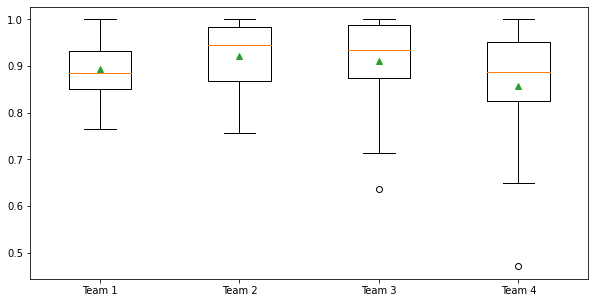

== Border-dilated strict IoU ==
Team 1 : accuracy = 0.891 +-0.069
Team 2 : accuracy = 0.920 +-0.074
Team 3 : accuracy = 0.908 +-0.091
Team 4 : accuracy = 0.859 +-0.119
Friedman p-value: 0.05183710771889888


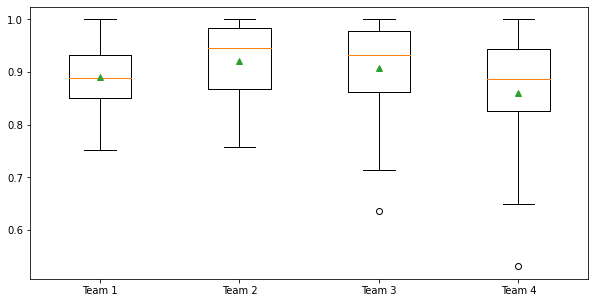

== Border-removed centroid ==
Team 1 : accuracy = 0.866 +-0.080
Team 2 : accuracy = 0.910 +-0.071
Team 3 : accuracy = 0.876 +-0.096
Team 4 : accuracy = 0.829 +-0.138
Friedman p-value: 0.0238073793704559
          0         1         2         3
0  1.000000  0.547298  0.823993  0.451717
1  0.547298  1.000000  0.900000  0.026798
2  0.823993  0.900000  1.000000  0.097852
3  0.451717  0.026798  0.097852  1.000000


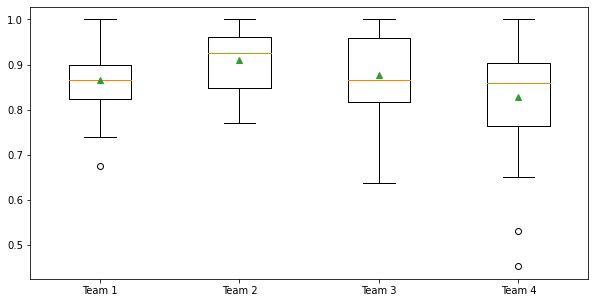

== Border-dilated centroid ==
Team 1 : accuracy = 0.866 +-0.080
Team 2 : accuracy = 0.910 +-0.071
Team 3 : accuracy = 0.876 +-0.096
Team 4 : accuracy = 0.829 +-0.138
Friedman p-value: 0.0238073793704559
          0         1         2         3
0  1.000000  0.547298  0.823993  0.451717
1  0.547298  1.000000  0.900000  0.026798
2  0.823993  0.900000  1.000000  0.097852
3  0.451717  0.026798  0.097852  1.000000


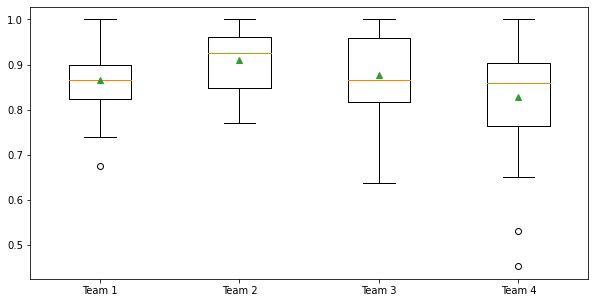

In [30]:
for ide,ext in enumerate(methods):
    print(f"== {methods[ext]} ==")
    teamAccs = [[] for _ in teams]
    for idt,team in enumerate(teams):
        accs = []
        for SM in teamSM[idt][ext]:
            classif = SM.compute_classification_scores()
            accs.append(classif['overall_acc'])
        print(f"Team {idt+1} : accuracy = {statistics.mean(accs):.3f} +-{statistics.stdev(accs):.3f}")
        teamAccs[idt] = accs
    
    s,pvalue = friedmanchisquare(*teamAccs)
    print(f"Friedman p-value: {pvalue}")
    if pvalue < 0.05:
        pvals = sp.posthoc_nemenyi_friedman(np.array(teamAccs).T)
        print(pvals)

    plt.figure(figsize=(10,5))
    plt.boxplot(teamAccs, showmeans=True, labels=[f"Team {idt+1}" for idt in range(4)])
    plt.show()

Rest of **Table 2** (+ all results for 3 other methods + additional plot with precision/recall, colors = team and shape = class)


=== Border-removed strict IoU ===

**Team 1**

         	prec	rec	f1
epithelial	0.868	0.957	0.885
lymphocyte	0.812	0.986	0.885
neutrophil	0.895	0.705	0.733
macrophage	0.991	0.859	0.912

**Team 2**

         	prec	rec	f1
epithelial	0.786	0.979	0.812
lymphocyte	0.920	0.952	0.930
neutrophil	0.889	0.835	0.806
macrophage	0.887	0.880	0.846

**Team 3**

         	prec	rec	f1
epithelial	0.882	0.984	0.922
lymphocyte	0.899	0.928	0.887
neutrophil	0.957	0.846	0.883
macrophage	0.937	0.843	0.878

**Team 4**

         	prec	rec	f1
epithelial	0.762	0.953	0.786
lymphocyte	0.831	0.960	0.876
neutrophil	0.871	0.677	0.685
macrophage	0.933	0.768	0.791


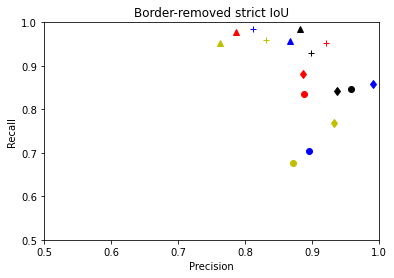


=== Border-dilated strict IoU ===

**Team 1**

         	prec	rec	f1
epithelial	0.862	0.956	0.881
lymphocyte	0.811	0.985	0.884
neutrophil	0.895	0.703	0.731
macrophage	0.991	0.852	0.907

**Team 2**

         	prec	rec	f1
epithelial	0.787	0.979	0.813
lymphocyte	0.913	0.952	0.926
neutrophil	0.890	0.824	0.801
macrophage	0.888	0.885	0.849

**Team 3**

         	prec	rec	f1
epithelial	0.884	0.984	0.923
lymphocyte	0.894	0.930	0.885
neutrophil	0.952	0.839	0.874
macrophage	0.937	0.838	0.874

**Team 4**

         	prec	rec	f1
epithelial	0.751	0.952	0.779
lymphocyte	0.832	0.956	0.876
neutrophil	0.885	0.691	0.710
macrophage	0.933	0.768	0.791


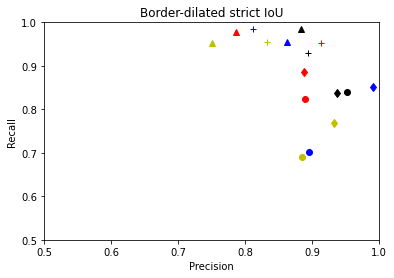


=== Border-removed centroid ===

**Team 1**

         	prec	rec	f1
epithelial	0.773	0.954	0.812
lymphocyte	0.798	0.981	0.874
neutrophil	0.890	0.705	0.730
macrophage	0.990	0.747	0.829

**Team 2**

         	prec	rec	f1
epithelial	0.765	0.977	0.801
lymphocyte	0.907	0.946	0.920
neutrophil	0.886	0.821	0.799
macrophage	0.880	0.847	0.830

**Team 3**

         	prec	rec	f1
epithelial	0.823	0.984	0.885
lymphocyte	0.834	0.921	0.867
neutrophil	0.948	0.820	0.857
macrophage	0.936	0.719	0.787

**Team 4**

         	prec	rec	f1
epithelial	0.705	0.951	0.753
lymphocyte	0.814	0.939	0.855
neutrophil	0.880	0.687	0.704
macrophage	0.932	0.657	0.707


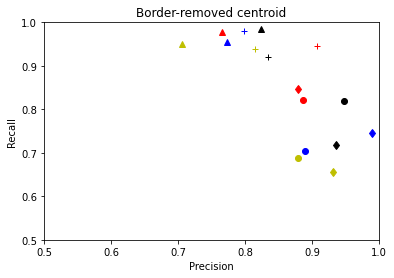


=== Border-dilated centroid ===

**Team 1**

         	prec	rec	f1
epithelial	0.773	0.954	0.812
lymphocyte	0.798	0.981	0.874
neutrophil	0.890	0.705	0.730
macrophage	0.990	0.747	0.829

**Team 2**

         	prec	rec	f1
epithelial	0.765	0.978	0.801
lymphocyte	0.907	0.946	0.920
neutrophil	0.886	0.821	0.799
macrophage	0.880	0.847	0.830

**Team 3**

         	prec	rec	f1
epithelial	0.824	0.984	0.885
lymphocyte	0.834	0.921	0.867
neutrophil	0.948	0.820	0.857
macrophage	0.936	0.719	0.787

**Team 4**

         	prec	rec	f1
epithelial	0.705	0.952	0.754
lymphocyte	0.814	0.939	0.855
neutrophil	0.880	0.687	0.704
macrophage	0.932	0.657	0.707


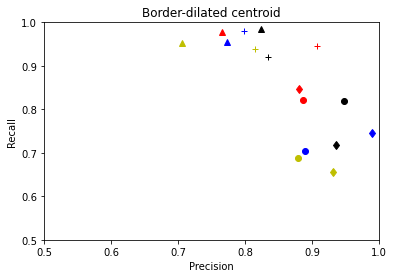

In [31]:
symbols = ['^', '+', 'o', 'd']
colors = ['b','r','k','y']

all_f1s = [[[[] for _ in teams] for _ in range(4)] for _ in methods]

for idm,ext in enumerate(methods):
    print(f"\n=== {methods[ext]} ===")
    plt.figure()
    for idt,team in enumerate(teams):
        precs = [[] for _ in range(4)]
        recs = [[] for _ in range(4)]
        f1s = [[] for _ in range(4)]
        #cm = np.zeros((5,5))
        for SM in teamSM[idt][ext]:
            classif = SM.compute_classification_scores()
            classid = 0
            for prec,rec,f1 in zip(classif['class_prec'], classif['class_rec'], classif['class_f1']):
                precs[classid] += [prec] if prec is not None else []
                recs[classid] += [rec] if rec is not None else []
                f1s[classid] += [f1] if f1 is not None else []
                if f1 is not None:
                    all_f1s[idm][classid][idt].append(f1)
                classid += 1
            #cm += SM.cm
        print(f'\n**Team {idt+1}**\n')
        # display scores as table:
        output_table = [['         ', 'prec', 'rec', 'f1']]
        for classid in range(4):
            plt.plot(statistics.mean(precs[classid]), statistics.mean(recs[classid]), f"{colors[idt]}{symbols[classid]}")
            output_table.append([ClassLabels.get_label_from_channel(classid), f"{statistics.mean(precs[classid]):.3f}", f"{statistics.mean(recs[classid]):.3f}", f"{statistics.mean(f1s[classid]):.3f}"])
        for line in output_table:
            print('\t'.join(line))
        #print(f"{cm.astype('int')}")
    plt.title(methods[ext])
    plt.xlabel("Precision")
    plt.ylabel("Recall")
    plt.xlim([0.5,1])
    plt.ylim([0.5,1])
    plt.show()

**Table 3** (raw confusion matrices, with all four methods)

In [32]:
for ext in methods:
    print(f"\n=== {methods[ext]} ===")
    for idt,team in enumerate(teams):
        cm = np.zeros((5,5))
        for SM in teamSM[idt][ext]:
            cm += SM.cm
        print(f'\n**Team {idt+1}**\n')
        print(f"{cm.astype('int')}")


=== Border-removed strict IoU ===

**Team 1**

[[   0 1403  913   15   61]
 [ 907 6036  246    8   12]
 [ 575   78 7146    3    1]
 [  11    5   37  117    2]
 [ 107   14   11    7  168]]

**Team 2**

[[   0 1013  698    4  297]
 [ 875 6192   85    0   57]
 [ 568  159 7066    4    6]
 [  10    1   17  134   10]
 [ 127   16    1   11  152]]

**Team 3**

[[   0 2221 1365   38   95]
 [1083 6031   94    0    1]
 [ 852   78 6870    3    0]
 [  11    1   19  138    3]
 [ 106   30    6    9  156]]

**Team 4**

[[   0 1028  782   10   13]
 [ 692 6198  295    2   22]
 [ 350  181 7269    3    0]
 [  14    3   38  115    2]
 [  90   30    7   25  155]]

=== Border-dilated strict IoU ===

**Team 1**

[[   0 1338  829   14   59]
 [ 831 6098  260    8   12]
 [ 507   79 7214    2    1]
 [   8    5   39  118    2]
 [ 102   16   11    8  170]]

**Team 2**

[[   0  962  629    5  285]
 [ 824 6240   88    0   57]
 [ 500  162 7131    4    6]
 [  10    1   18  133   10]
 [ 115   16    1   11  164]]

**Tea

**Table 4** IoU results + additional box-plots and relevant **statistical tests**

== Border-removed strict IoU ==
Team 1 : 0.786 +-0.031
Team 2 : 0.785 +-0.034
Team 3 : 0.788 +-0.027
Team 4 : 0.800 +-0.032
Friedman p-value = 0.01975827449216258
          0         1         2         3
0  1.000000  0.900000  0.900000  0.042567
1  0.900000  1.000000  0.900000  0.042567
2  0.900000  0.900000  1.000000  0.075303
3  0.042567  0.042567  0.075303  1.000000


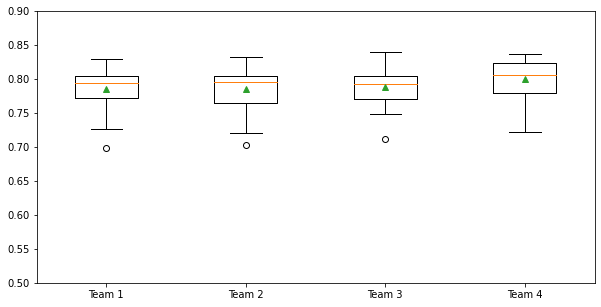

== Border-dilated strict IoU ==
Team 1 : 0.799 +-0.027
Team 2 : 0.795 +-0.029
Team 3 : 0.795 +-0.023
Team 4 : 0.793 +-0.028
Friedman p-value = 0.2933296061569843


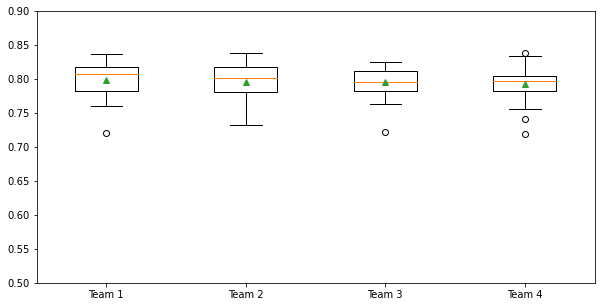

== Border-removed centroid ==
Team 1 : 0.744 +-0.068
Team 2 : 0.744 +-0.058
Team 3 : 0.741 +-0.055
Team 4 : 0.771 +-0.053
Friedman p-value = 0.0005100638540054314
          0         1         2         3
0  1.000000  0.854735  0.608787  0.042567
1  0.854735  1.000000  0.900000  0.003819
2  0.608787  0.900000  1.000000  0.001000
3  0.042567  0.003819  0.001000  1.000000


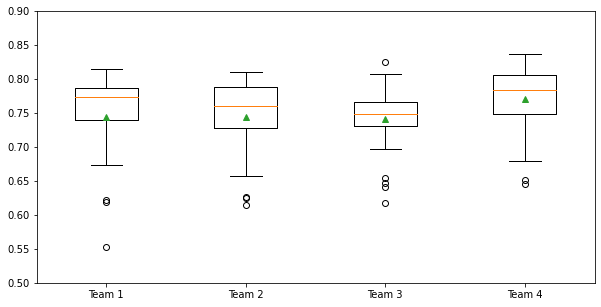

== Border-dilated centroid ==
Team 1 : 0.761 +-0.065
Team 2 : 0.762 +-0.054
Team 3 : 0.751 +-0.049
Team 4 : 0.766 +-0.045
Friedman p-value = 0.0442275935689761
          0         1         2         3
0  1.000000  0.900000  0.159276  0.900000
1  0.900000  1.000000  0.159276  0.900000
2  0.159276  0.159276  1.000000  0.042567
3  0.900000  0.900000  0.042567  1.000000


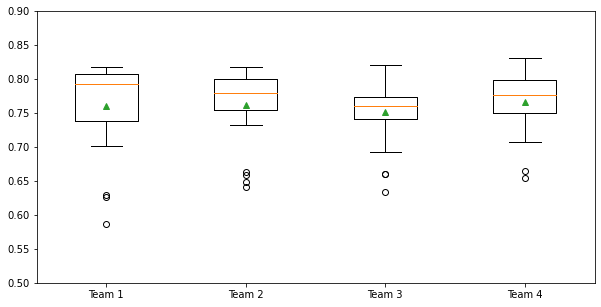

In [33]:
teamIoUs = [[] for _ in range(4)]

for idm,ext in enumerate(methods):
    print(f"== {methods[ext]} ==")
    teamIoUs[idm] = [[] for _ in teams]
    for idt,team in enumerate(teams):
        ious = []
        for SM in teamSM[idt][ext]:
            seg = SM.compute_segmentation_scores()
            ious.append(seg['aIoU'])
        print(f"Team {idt+1} : {statistics.mean(ious):.3f} +-{statistics.stdev(ious):.3f}")
        teamIoUs[idm][idt] = ious
    
    s,pvalue = friedmanchisquare(*teamIoUs[idm])
    print(f"Friedman p-value = {pvalue}")
    if pvalue < 0.05:
        pvals = sp.posthoc_nemenyi_friedman(np.array(teamIoUs[idm]).T)
        print(pvals)
    plt.figure(figsize=(10,5))
    plt.boxplot(teamIoUs[idm], showmeans=True, labels=[f"Team {idt+1}" for idt in range(4)])
    plt.ylim([0.5,0.9])
    plt.show()

Additional per-class results

In [34]:
for idm,ext in enumerate(methods):
    print(f"{methods[ext]}")
    output_table = [['     ', 'Epithelial', 'Lymphocyte', 'Neutrophil       ', 'Macrophage']]
    for idt,team in enumerate(teams):
        ious_per_class = [[] for _ in range(4)]
        for SM in teamSM[idt][ext]:
            seg = SM.compute_segmentation_scores()
            for i in range(4):
                if seg['IoUc'][i] is not None:
                    ious_per_class[i].append(seg['IoUc'][i])
        
        output_table.append([f"Team {idt+1}"] + [f"{statistics.mean(ious_per_class[classid]):.3f} +- {statistics.stdev(ious_per_class[classid]):.3f}" for classid in range(4)])

    for row in output_table:
        print('\t'.join(row))

Border-removed strict IoU
     	Epithelial	Lymphocyte	Neutrophil       	Macrophage
Team 1	0.807 +- 0.020	0.759 +- 0.040	0.792 +- 0.048	0.801 +- 0.070
Team 2	0.817 +- 0.018	0.772 +- 0.037	0.789 +- 0.045	0.759 +- 0.098
Team 3	0.814 +- 0.019	0.761 +- 0.039	0.759 +- 0.054	0.828 +- 0.050
Team 4	0.821 +- 0.019	0.773 +- 0.043	0.786 +- 0.060	0.830 +- 0.052
Border-dilated strict IoU
     	Epithelial	Lymphocyte	Neutrophil       	Macrophage
Team 1	0.812 +- 0.019	0.777 +- 0.036	0.806 +- 0.033	0.815 +- 0.053
Team 2	0.824 +- 0.017	0.782 +- 0.034	0.811 +- 0.040	0.766 +- 0.084
Team 3	0.797 +- 0.021	0.774 +- 0.032	0.798 +- 0.041	0.822 +- 0.045
Team 4	0.805 +- 0.024	0.760 +- 0.041	0.789 +- 0.046	0.834 +- 0.048
Border-removed centroid
     	Epithelial	Lymphocyte	Neutrophil       	Macrophage
Team 1	0.780 +- 0.026	0.747 +- 0.040	0.782 +- 0.066	0.657 +- 0.207
Team 2	0.801 +- 0.019	0.763 +- 0.037	0.779 +- 0.058	0.618 +- 0.188
Team 3	0.791 +- 0.024	0.750 +- 0.041	0.747 +- 0.070	0.666 +- 0.180
Team 4	0.811 +- 

**Table 4** (Hausdorff Distances) + related **statistical tests**

Border-removed strict IoU
Team 1 : 3.759 += 0.715 (median = 3.694)
Team 2 : 3.588 += 0.573 (median = 3.568)
Team 3 : 4.471 += 0.979 (median = 4.414)
Team 4 : 3.453 += 0.595 (median = 3.347)
Friedman p-value = 1.165447329108625e-13
          0         1         2         3
0  1.000000  0.097852  0.005604  0.001000
1  0.097852  1.000000  0.001000  0.198718
2  0.005604  0.001000  1.000000  0.001000
3  0.001000  0.198718  0.001000  1.000000


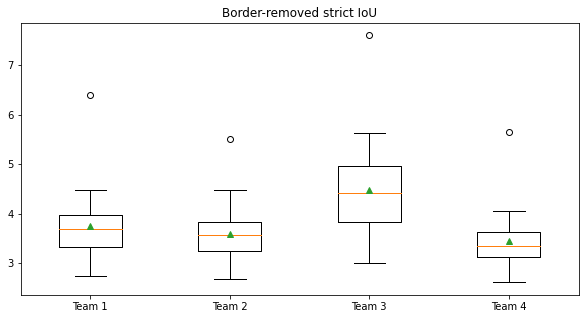

Border-dilated strict IoU
Team 1 : 3.742 += 0.722 (median = 3.719)
Team 2 : 3.602 += 0.555 (median = 3.572)
Team 3 : 4.470 += 0.940 (median = 4.468)
Team 4 : 3.702 += 0.570 (median = 3.667)
Friedman p-value = 6.191127350489051e-09
          0         1         2         3
0  1.000000  0.042567  0.001709  0.854735
1  0.042567  1.000000  0.001000  0.244488
2  0.001709  0.001000  1.000000  0.001000
3  0.854735  0.244488  0.001000  1.000000


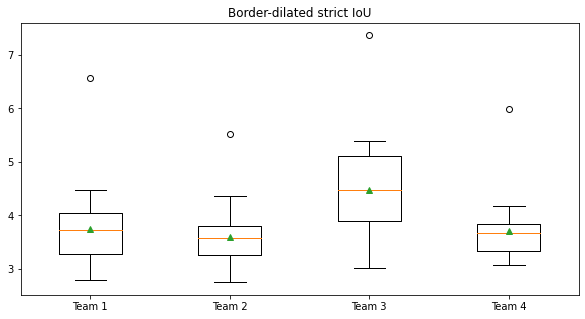

Border-removed centroid
Team 1 : 4.425 += 1.108 (median = 4.202)
Team 2 : 4.097 += 0.814 (median = 4.189)
Team 3 : 5.242 += 1.338 (median = 5.195)
Team 4 : 3.814 += 0.823 (median = 3.821)
Friedman p-value = 2.227305822434807e-14
          0         1         2         3
0  1.000000  0.354855  0.008117  0.001000
1  0.354855  1.000000  0.001000  0.008117
2  0.008117  0.001000  1.000000  0.001000
3  0.001000  0.008117  0.001000  1.000000


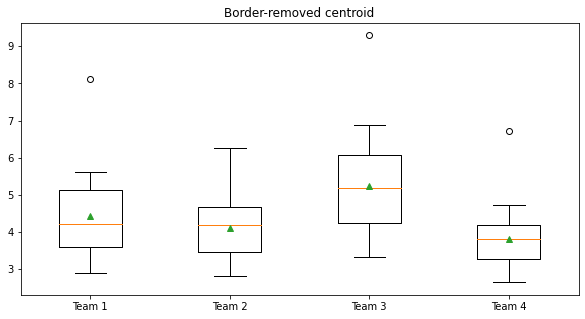

Border-dilated centroid
Team 1 : 4.344 += 1.092 (median = 4.087)
Team 2 : 4.051 += 0.780 (median = 4.132)
Team 3 : 5.334 += 1.426 (median = 5.386)
Team 4 : 4.075 += 0.807 (median = 4.093)
Friedman p-value = 2.205719104608207e-09
          0         1         2         3
0  1.000000  0.042567  0.003819  0.244488
1  0.042567  1.000000  0.001000  0.854735
2  0.003819  0.001000  1.000000  0.001000
3  0.244488  0.854735  0.001000  1.000000


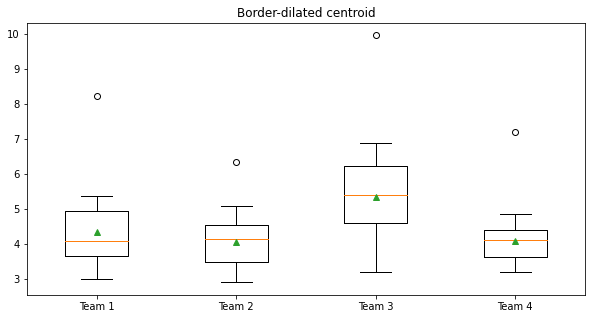

In [6]:
with open(os.path.join(DIRECTORY, "all_hds.pkl"), "rb") as fp:
    all_hds = pickle.load(fp)
with open(os.path.join(DIRECTORY, "all_hds_per_class.pkl"), "rb") as fp:
    all_hds_per_class = pickle.load(fp)

for ext in methods:
    print(f"{methods[ext]}")
    hds = []
    for idt,team in enumerate(all_hds):
        print(f"Team {idt+1} : {statistics.mean(all_hds[team][ext]):.3f} += {statistics.stdev(all_hds[team][ext]):.3f} (median = {statistics.median(all_hds[team][ext]):.3f})")
        hds.append(all_hds[team][ext])
    s,pvalue = friedmanchisquare(*hds)
    print(f"Friedman p-value = {pvalue}")
    if pvalue < 0.05:
        pvals = sp.posthoc_nemenyi_friedman(np.array(hds).T)
        print(pvals)
    plt.figure(figsize=(10,5))
    plt.boxplot(hds, labels=[f"Team {idt+1}" for idt in range(4)], showmeans=True)
    plt.title(methods[ext])
    plt.show()

Additional per-class results

In [7]:
for ext in methods:
    print(f"{methods[ext]}")
    output_table = [['     ', 'Epithelial', 'Lymphocyte', 'Neutrophil       ', 'Macrophage']]
    for idt,team in enumerate(all_hds):
        #print(f"**Team {idt+1}**")
        output_table.append([f"Team {idt+1}"] + [f"{statistics.mean(all_hds_per_class[team][ext][classid]):.3f} += {statistics.stdev(all_hds_per_class[team][ext][classid]):.3f}" for classid in range(4)])
        #for classid in range(4):
        #    print(f"{ClassLabels.get_label_from_channel(classid)} : {statistics.mean(all_hds_per_class[team][ext][classid]):.3f} += {statistics.stdev(all_hds_per_class[team][ext][classid]):.3f}")
    for row in output_table:
        print('\t'.join(row))

Border-removed strict IoU
     	Epithelial	Lymphocyte	Neutrophil       	Macrophage
Team 1	4.413 += 0.775	3.168 += 0.556	3.645 += 0.786	9.168 += 5.034
Team 2	4.155 += 0.595	2.988 += 0.534	3.703 += 0.876	13.436 += 12.094
Team 3	5.345 += 1.068	3.627 += 0.658	4.335 += 1.259	14.426 += 23.694
Team 4	3.997 += 0.659	2.980 += 0.459	3.597 += 0.808	7.927 += 4.772
Border-dilated strict IoU
     	Epithelial	Lymphocyte	Neutrophil       	Macrophage
Team 1	4.471 += 0.860	3.078 += 0.385	3.622 += 0.766	9.085 += 4.841
Team 2	4.177 += 0.688	2.988 += 0.301	3.504 += 0.843	12.735 += 8.686
Team 3	5.566 += 0.976	3.530 += 0.594	3.921 += 1.224	14.886 += 23.840
Team 4	4.351 += 0.698	3.222 += 0.434	3.870 += 0.813	7.686 += 4.511
Border-removed centroid
     	Epithelial	Lymphocyte	Neutrophil       	Macrophage
Team 1	5.357 += 1.306	3.409 += 0.589	3.852 += 1.210	18.510 += 15.649
Team 2	4.663 += 0.799	3.155 += 0.525	4.117 += 1.627	20.632 += 14.944
Team 3	6.387 += 1.360	3.943 += 0.759	4.629 += 1.576	18.984 += 17.091
Tea

### Additional material

**Size and number of detected objects depending on the n-ary mask generation method**

The sensitivity of certain teams to the small changes in n-ary mask generation and in matching rules may also be interesting to analyze. For instance, we can ask why the detection performance of Team 3 decreases so much when using the border-dilated n-ary masks generation method. A possibility could be that Team 3 tends to overestimate the size of the objects. The results below hint at something slightly more complex: Team 3’s prediction masks are, on average, similar in size to Team 4’s ones, and in fact both Teams overestimate the size of the objects in the border-dilated version. 

What really sets Team 3 apart is that the number of predicted objects varies depending on the n-ary mask generation method. This is due to the fact that Team 3 predicts a lot of objects inside regions marked as "ambiguous", which are therefore normally not counted in the assessments. However, with the border-dilated version (which should be closer to the raw n-ary masks produced by the teams), parts of these objects end up outside of the ambiguous regions and start to affect the results. To avoid this undesirable effect, a more robust method that removes any object that largely overlaps an ambiguous region could be used, as already proposed in the original PQ publication of *Kirillov et al*.

In [37]:
nary_methods = ['border-removed', 'border-dilated']
for idt,team in enumerate(teams):
    print(f"== Team {idt+1} ==")
    for nary in nary_methods:
        n_obj = 0
        n_size = 0
        for patient in teams_masks[team][nary]:
            for im in teams_masks[team][nary][patient]:
                nonambiguous_mask = gt_nary_masks[patient][im][...,1]!=5
                
                n_obj += len(np.unique(teams_masks[team][nary][patient][im][...,0]*nonambiguous_mask))-1
                n_size += ((teams_masks[team][nary][patient][im][...,0]*nonambiguous_mask)>0).sum()
        print(f"{nary}: {n_obj} (avg size = {n_size/n_obj:.2f})")

== Team 1 ==
border-removed: 16283 (avg size = 445.21)
border-dilated: 16283 (avg size = 512.30)
== Team 2 ==
border-removed: 15923 (avg size = 459.64)
border-dilated: 15923 (avg size = 528.50)
== Team 3 ==
border-removed: 17158 (avg size = 494.64)
border-dilated: 17995 (avg size = 543.44)
== Team 4 ==
border-removed: 16178 (avg size = 497.34)
border-dilated: 16178 (avg size = 568.70)


# Random sampling of image results:

Change seed to see other results. Results shown in publication come from seed 0, 1 and 2. 

Selected image: TCGA-DW-7963-01Z-00-DX1_1


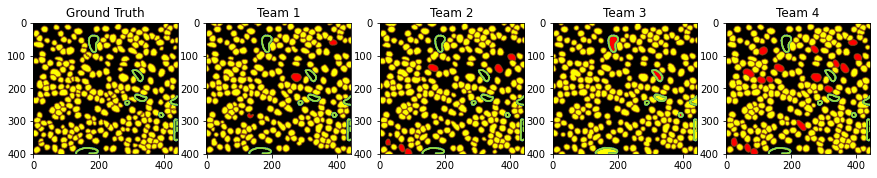

Selected image: TCGA-DW-7838-01Z-00-DX1_2


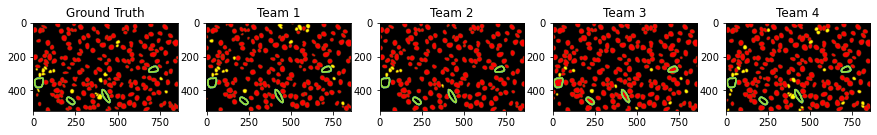

Selected image: TCGA-G9-6367-01Z-00-DX1_3


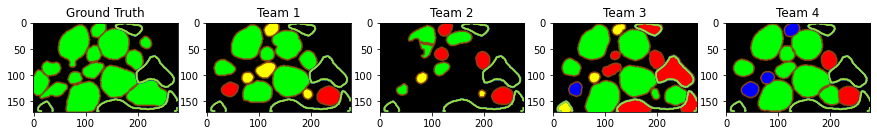

Selected image: TCGA-F9-A8NY-01Z-00-DX1_4


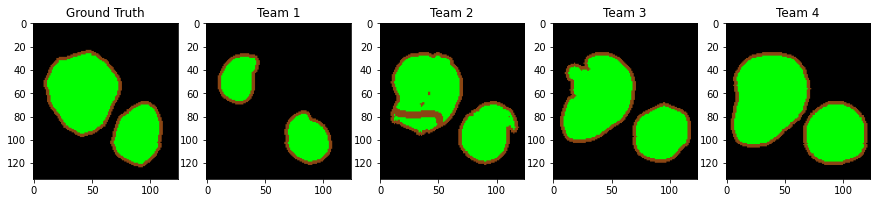

Selected image: TCGA-73-4662-01Z-00-DX1_002


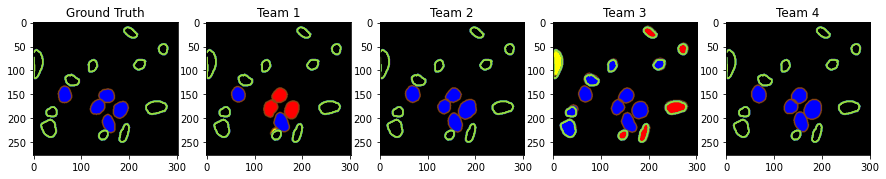

Selected image: TCGA-2Z-A9JN-01Z-00-DX1_4


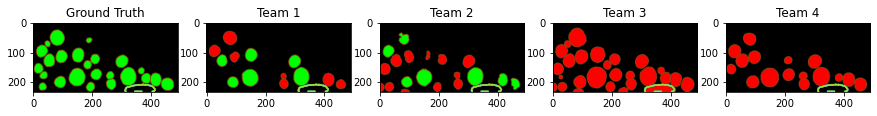

Selected image: TCGA-VP-A87H-01Z-00-DX1_5


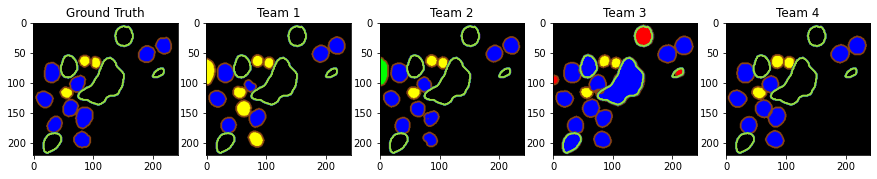

Selected image: TCGA-DW-7963-01Z-00-DX1_4


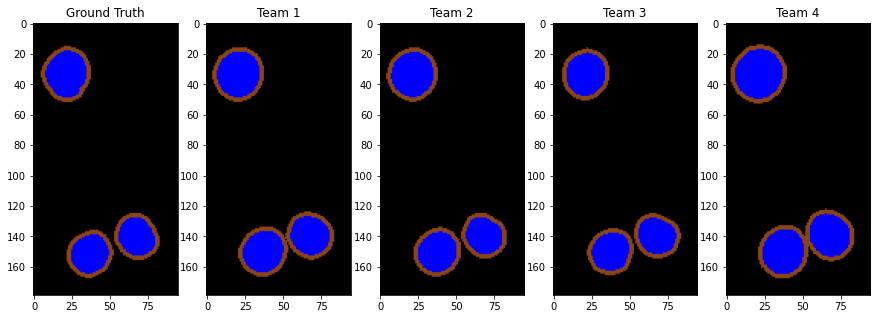

Selected image: TCGA-2Z-A9JG-01Z-00-DX1_5


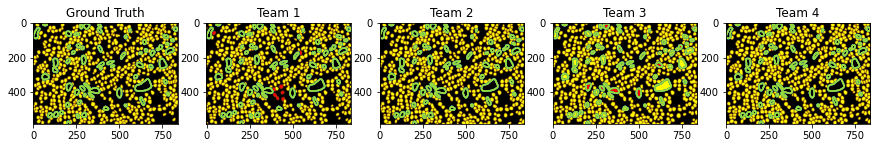

Selected image: TCGA-D8-A3Z6-01Z-00-DX2_002


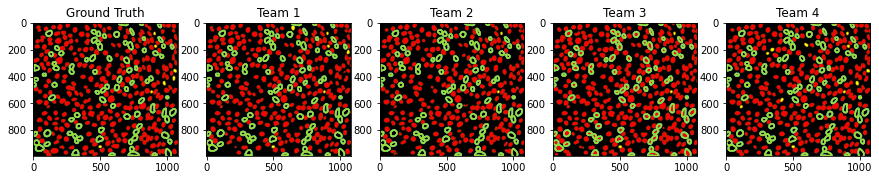

In [41]:
random.seed(0)
for _ in range(10):
    patient,im = select_random_image(gt_dir)

    plt.figure(figsize=(15,10))
    ccgt_dir = os.path.join(DIRECTORY, "MoNuSAC_Testing_Color_Coded_Masks")
    patient_dir = os.path.join(ccgt_dir, patient)
    gt_cc = imread(os.path.join(patient_dir, f"{im}_RGB_mask.tif.tif"))
    patient_dir = os.path.join(gt_dir, patient)
    gt_nary = np.load(os.path.join(patient_dir, f"{im}_nary.npy"))
    #plt.subplot(1,6,1)
    #plt.imshow(imread(os.path.join(patient_dir, f"{im}.tif")))
    #plt.contour(gt_nary[...,1]==5) # highlight ambiguous regions
    #plt.title("RGB")
    plt.subplot(1,5,1)
    plt.imshow(gt_cc)
    if( (gt_nary[...,1]==5).sum() > 0 ):
        plt.contour(gt_nary[...,1]==5) # highlight ambiguous regions
    plt.title("Ground Truth")
    for idt,team in enumerate(teams):
        team_dir = os.path.join(teams_dir, team)
        patient_dir = os.path.join(team_dir, patient)
        team_cc = imread(os.path.join(patient_dir, f"{im}_mask.png.tif"))
        plt.subplot(1,5,idt+2)
        plt.imshow(team_cc)
        if( (gt_nary[...,1]==5).sum() > 0 ):
            plt.contour(gt_nary[...,1]==5) # highlight ambiguous regions
        plt.title(f"Team {idt+1}")
    plt.show()